# Moment Estimation of transcriptional parameters

From Bagnall et al. 2020



$$
\begin{align}
   b_m &= \frac{\sigma^2}{\mu} \\\
   \\\
   f_m &= \frac{\mu}{b_m-1} \\\
   \\\
   f_m &= \frac{\mu}{\sigma^2-\mu} \\\
   \\\
\end{align}    
$$

- Moments - TSS quantification
    - By timepoint
    - Gene data
    - Enhancer data


┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/irene/.julia/packages/PyPlot/XHEG0/src/init.jl:118
┌ Warning: RCall.jl: Loading required package: grid
└ @ RCall /Users/irene/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: 
│ Attaching package: ‘DescTools’
│ 
│ The following objects are masked from ‘package:psych’:
│ 
│     AUC, ICC, SD
│ 
└ @ RCall /Users/irene/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: 
│ Attaching package: ‘rcompanion’
│ 
│ The following object is masked from ‘package:psych’:
│ 
│     phi
│ 
└ @ RCall /Users/irene/.julia/packages/RCall/eRsxl/src/io.jl:160


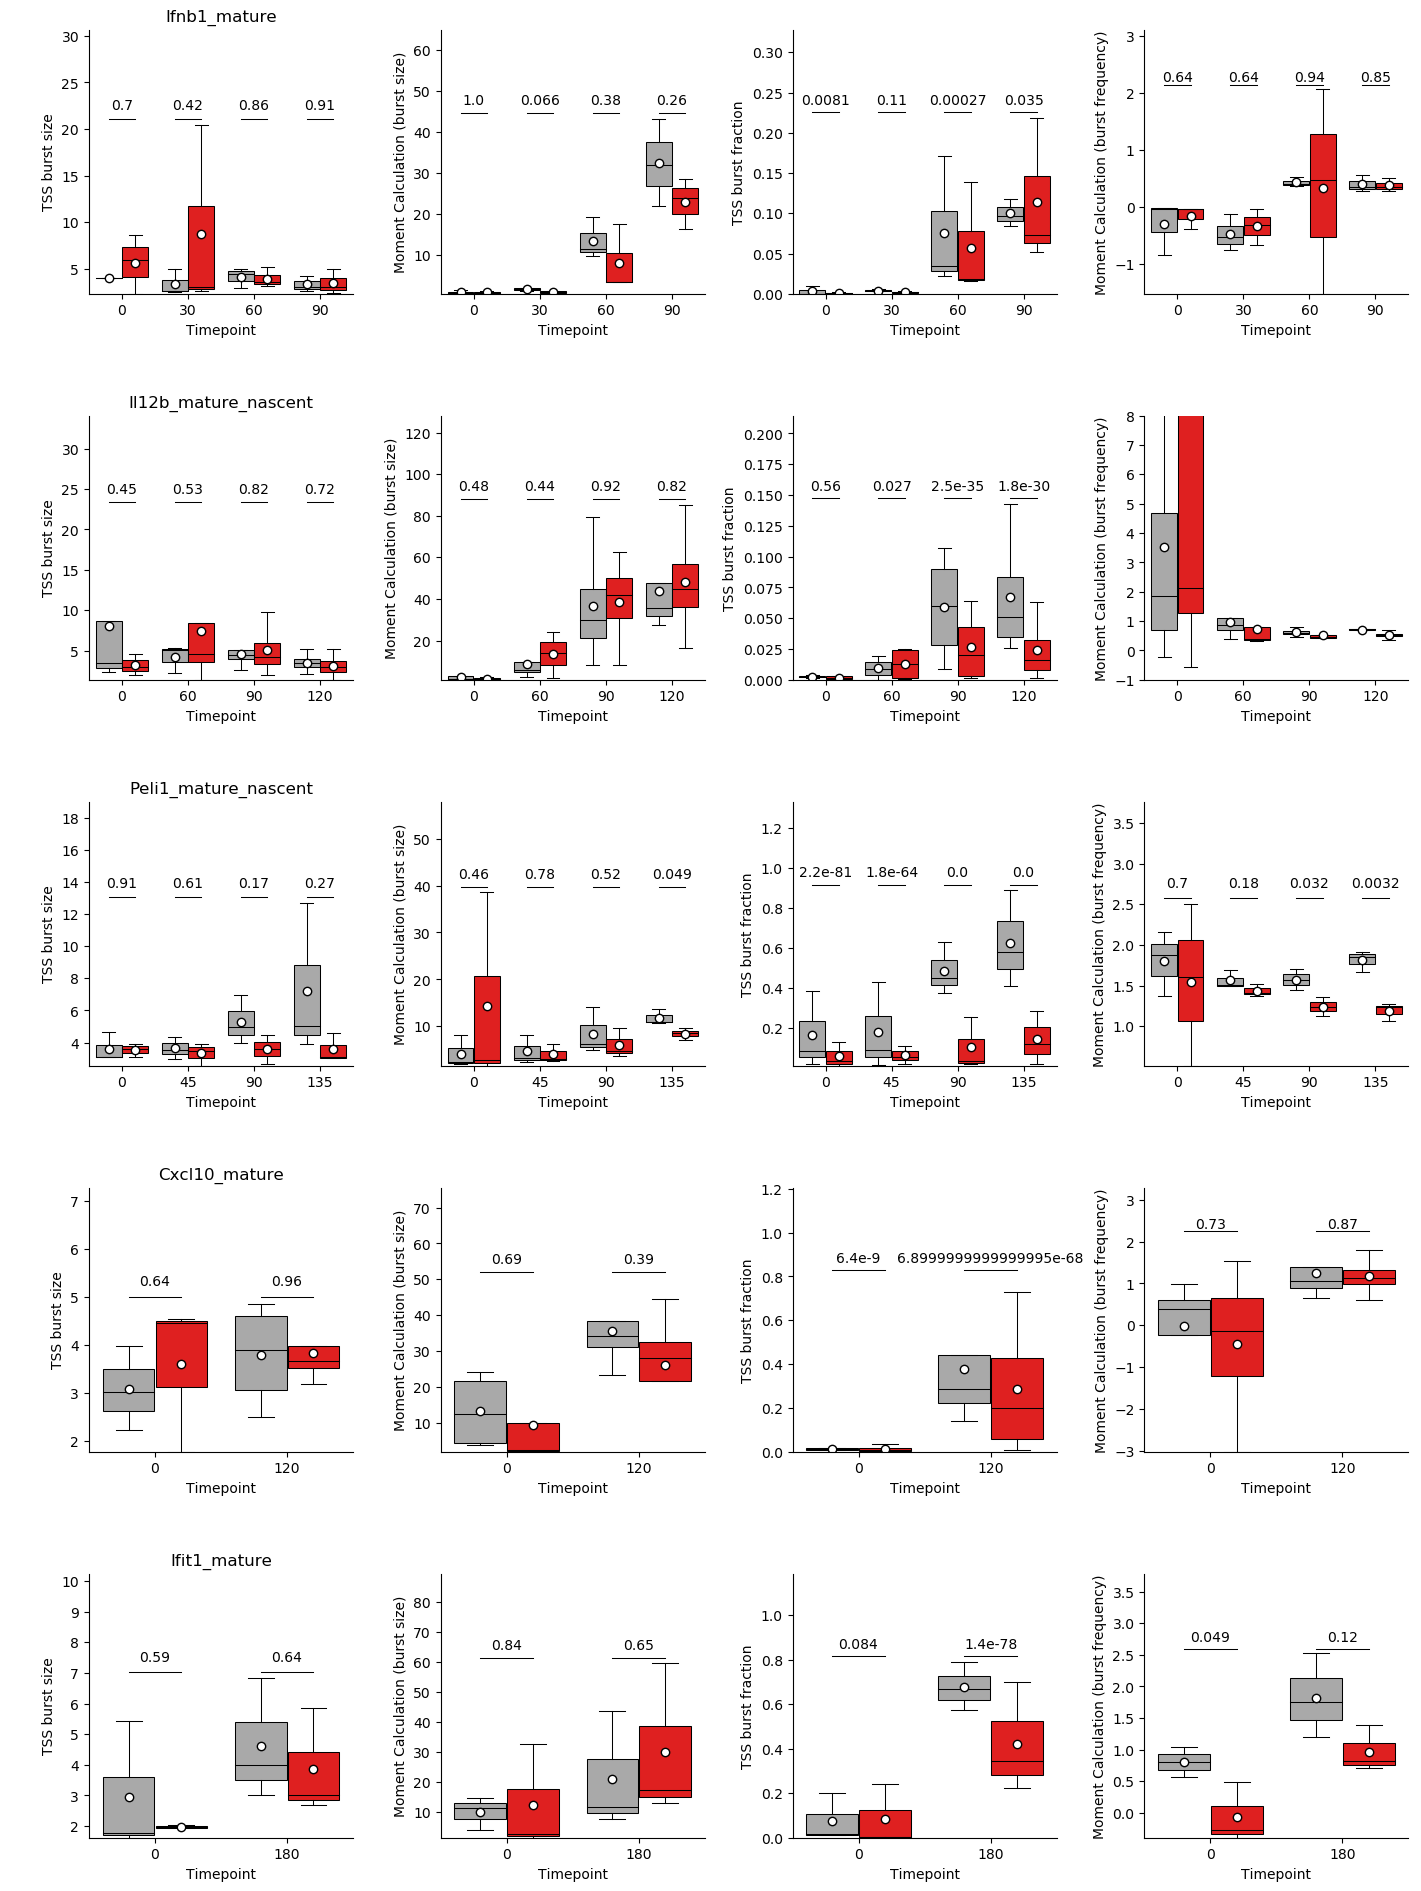

┌ Warning: RCall.jl: 
│ Attaching package: ‘dplyr’
│ 
│ The following objects are masked from ‘package:stats’:
│ 
│     filter, lag
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     intersect, setdiff, setequal, union
│ 
└ @ RCall /Users/irene/.julia/packages/RCall/eRsxl/src/io.jl:160


In [1]:
ENV["Code"] = "../../Code"
for folder in readdir(ENV["Code"]); push!(LOAD_PATH, normpath(ENV["Code"], folder));end

include("momentcalculation.jl")
include("testfunctions.jl")

function f_plot(y, bf_probe, probe; test = anova)
    timepoints = unique(bf_probe[!,:Timepoint])
    ntim = length(timepoints)
    maxy = maximum(bf_probe[!,y][.!isnan.(bf_probe[!,y])])

    Seaborn.boxplot(data = Pandas.DataFrame(bf_probe), x= "Timepoint", y = y, hue = "Genotype", 
    palette = Dict("WT"=>"darkgray", "Rad21KO" => "red"),
    showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()

    timepoints =string.( sort(parse.(Int, unique(bf_probe[!,:Timepoint]))))
   maxy = maximum(bf_probe[!,y][.!isnan.(bf_probe[!,y])])
    miny = minimum(bf_probe[!,y][.!isnan.(bf_probe[!,y])])

    s = bf_probe[.!isnan.(bf_probe[!,y]), :]
    s[!,y] = [ii for ii in s[!,y]]
    

    
    for ii in 1:ntim
        plt.plot([ii-1.2, ii-0.8], [1.03*maxy, 1.03*maxy], c = "black")
        o = s[s[!,:Timepoint].==(timepoints[ii]),:]
        a = o[o[!,:Genotype].=="WT",y]
        b = o[o[!,:Genotype].=="Rad21KO",y]
        repa = o[o[!,:Genotype].=="WT",:Rep]
        repb = o[o[!,:Genotype].=="Rad21KO",:Rep]

  
        tag = "NA"
        tim = timepoints[ii]
        if test == do_mantelhaen
            tag =  round(test(bf_probe, "WT_"*string(tim), "Rad21KO_"*string(tim)), sigdigits = 2)
        else 
            tag =  round(test(a, b, repa, repb), sigdigits = 2)

        end
          
        
        plt.annotate("$tag", [mean([ii-1.2, ii-0.8]), 1.1*maxy], ha = "center", va = "center")
    end
    

    ylim(miny, 1.5maxy)
    plt.tight_layout(); squareplot(); legend_removal(), line075black()
    
    
end

function TSS_BF(bf_probe, probe)
    f_plot("TSS_BF",bf_probe, probe, test = do_mantelhaen)
    ylabel("TSS burst fraction")
end

function TSS_BS(bf_probe, probe)
    f_plot("TSS_BS",bf_probe, probe)
    ylabel("TSS burst size")
end

function momment_BF(bf_probe, probe)
    f_plot("momment_BF",bf_probe, probe)
        if probe == "Il12b_mature_nascent"
               ylim(-1, 8)
    plt.tight_layout(); squareplot(); legend_removal(), line075black()
        end
    ylabel("Moment Calculation (burst frequency)")
end

function momment_BS(bf_probe, probe)
    f_plot("momment_BS",bf_probe, probe)
    ylabel("Moment Calculation (burst size)")
end


function plot_probe_genedata(probe; c = 4, r = 4, n = 1, folder = "GeneData", lims = nothing)
    probe_df = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*folder*"/"*probe*".csv", DataFrames.DataFrame)
    
    
    
    
    if occursin("Prdm1", probe)
        probe_df = probe_df[probe_df[!,:Timepoint].!=30, :]
        probe_df = probe_df[probe_df[!,:Timepoint].!=90, :]
    end
    #probe_df = probe_df[string.(probe_df[!,:Timepoint]).!="0", :]    
    timepoints = unique(probe_df[!,:Timepoint])
    ntim = length(timepoints)
    
    
    bf_probe = bootstrap_mean_std(probe_df, probe, limit = 1)
    subplot(c,r,c*(n-1)+1-(n-1))
    TSS_BS(bf_probe, probe)
    title(probe)
    subplot(c,r,c*(n-1)+2-(n-1))
    momment_BS(bf_probe, probe)
    subplot(c,r,c*(n-1)+3-(n-1))
    TSS_BF(bf_probe, probe)
    subplot(c,r,c*(n-1)+4-(n-1))
    momment_BF(bf_probe, probe)
    
    return bf_probe

end
    

figure(figsize = (14, 20))
df = vcat(plot_probe_genedata("Ifnb1_mature"; c = 5, r = 4, n = 1, folder = "CompleteSets"),
plot_probe_genedata("Il12b_mature_nascent"; c = 5, r = 4, n = 2, folder = "CompleteSets", lims = (0, 2)),
plot_probe_genedata("Peli1_mature_nascent"; c = 5, r = 4, n = 3, folder = "CompleteSets"),
plot_probe_genedata("Cxcl10_mature"; c = 5, r = 4, n = 4, folder = "CompleteSets"),
plot_probe_genedata("Ifit1_mature"; c = 5, r = 4, n = 5, folder = "CompleteSets"))
    savefigwithtext("bygenotype.png")

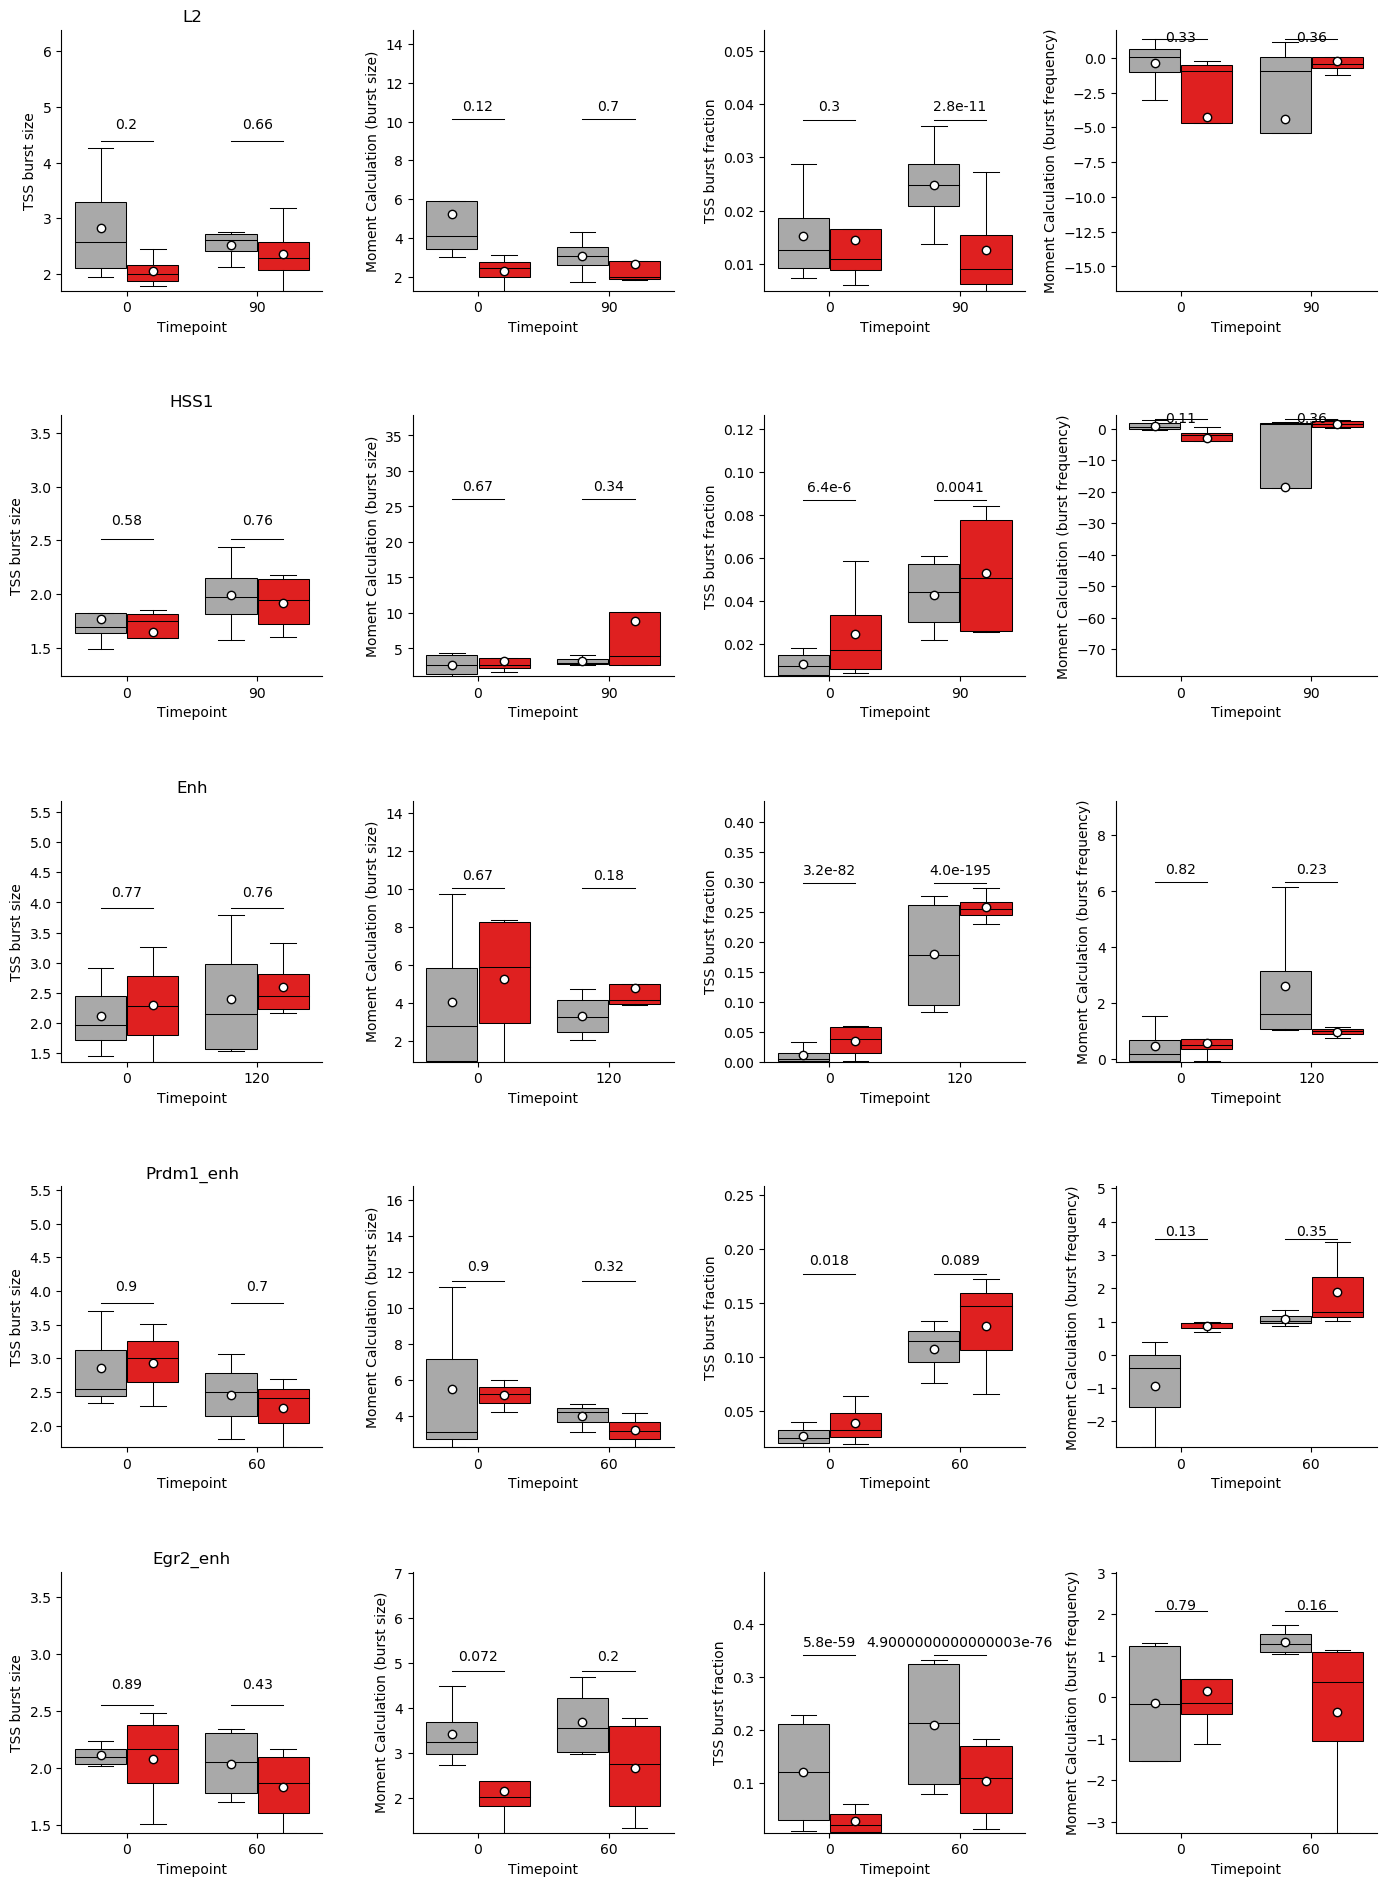

,Sample_Rep,Genotype,Timepoint,Rep,Sample,n_cells,nburst,Gene
,String,SubStri…,SubStri…,SubStri…,String,Any,Any,String
1,WT_0_1,WT,0,1,WT_0,441,181,Egr2_enh
2,WT_60_1,WT,60,1,WT_60,1717,1109,Egr2_enh
3,WT_60_2,WT,60,2,WT_60,1216,808,Egr2_enh
4,WT_0_2,WT,0,2,WT_0,476,217,Egr2_enh
5,Rad21KO_0_1,Rad21KO,0,1,Rad21KO_0,278,20,Egr2_enh
6,Rad21KO_60_1,Rad21KO,60,1,Rad21KO_60,814,299,Egr2_enh
7,Rad21KO_60_2,Rad21KO,60,2,Rad21KO_60,514,169,Egr2_enh
8,Rad21KO_0_2,Rad21KO,0,2,Rad21KO_0,611,74,Egr2_enh
9,WT_0_3,WT,0,3,WT_0,965,72,Egr2_enh


In [2]:
figure(figsize = (14, 20))
plot_probe_genedata("L2"; c = 5, r = 4, n = 1, folder = "GeneData")
plot_probe_genedata("HSS1"; c = 5, r = 4, n = 2, folder = "GeneData")
plot_probe_genedata("Enh"; c = 5, r = 4, n = 3, folder = "GeneData")
plot_probe_genedata("Prdm1_enh"; c = 5, r = 4, n = 4, folder = "GeneData")
a = plot_probe_genedata("Egr2_enh"; c = 5, r = 4, n = 5, folder = "GeneData")

In [3]:
import Pkg; Pkg.status()

      Status `~/.julia/environments/v1.6/Project.toml`
  [336ed68f] CSV v0.9.11
  [a93c6f00] DataFrames v0.22.7
  [31c24e10] Distributions v0.23.12
  [c2308a5c] FASTX v1.2.0
  [53c48c17] FixedPointNumbers v0.8.4
  [09f84164] HypothesisTests v0.10.2
  [7073ff75] IJulia v1.23.2
  [6a3955dd] ImageFiltering v0.6.21
  [6218d12a] ImageMagick v1.2.2
  [86fae568] ImageView v0.10.13
  [916415d5] Images v0.23.3
  [96684042] InformationMeasures v0.3.1
  [4138dd39] JLD v0.12.3
  [093fc24a] LightGraphs v1.3.5
  [10e44e05] MATLAB v0.8.0
  [f8716d33] MultipleTesting v0.4.1
  [eadc2687] Pandas v1.4.0
  [91a5bcdd] Plots v1.21.2
  [92933f4c] ProgressMeter v1.5.0
  [438e738f] PyCall v1.92.2
  [d330b81b] PyPlot v2.9.0
  [6f49c342] RCall v0.13.10
  [3646fa90] ScikitLearn v0.6.3
  [d2ef9438] Seaborn v0.4.1
  [2913bbd2] StatsBase v0.33.10


In [4]:
ENV["Code"] = "../../Code"
for folder in readdir(ENV["Code"]); push!(LOAD_PATH, normpath(ENV["Code"], folder));end

include(ENV["Code"]*"/../Code_Paper/Databases/Cuartero2018.jl")
include(ENV["Code"]*"/../Code_Paper/Databases/mm9.jl")

tb = df
gene = []
RNAseqcomp = []
GROseqcomp = []
smFISHcomp = []
log2FC_RNAseq = []
log2FC_GROseq = []
FC_BS= []
FC_BF = []
FC_BS_m= []
FC_BF_m = []
N_Cells = []


function addtolists()
    push!(gene, gene1)
"""    gro = Cuartero2018.GroseqDeseq(GROseqcomp1); 
    g = gro[gro[!,:GeneSymbol] .== split(gene1, "_")[1], "log2FoldChange"]
    if length(g)>0
        push!(log2FC_GROseq, g[1])
    else
        push!(log2FC_GROseq, NaN)
    end      

    push!(GROseqcomp, GROseqcomp1);"""
     rna = Cuartero2018.Cuartero2018Deseq(RNAseqcomp1); 
         r = rna[rna[!,:GeneSymbol] .== split(gene1, "_")[1], :log2FoldChange][1]; 
    push!(RNAseqcomp, RNAseqcomp1); push!(log2FC_RNAseq, r);

    smFISHsamples = split(smFISHcomp1);push!(smFISHcomp, smFISHcomp1)
    smfish = tb[[in(ii, smFISHsamples) for ii in tb[!,:Sample]], :]
     smfish = smfish[smfish[!,:Gene] .== gene1, :]
    n1 = sum(smfish[smfish[!,:Sample] .== smFISHsamples[1], :n_cells])
        n2 = sum(smfish[smfish[!,:Sample] .== smFISHsamples[end], :n_cells])
    push!(N_Cells,n1 + n2)   
    bf1 = Statistics.mean(smfish[smfish[!,:Sample] .== smFISHsamples[1], "TSS_BF"])
    bf2 = Statistics.mean(smfish[smfish[!,:Sample] .== smFISHsamples[end], "TSS_BF"])
    oddsratio = bf1/bf2
    push!(FC_BF, oddsratio)
        
    bf1 = Statistics.mean(smfish[smfish[!,:Sample] .== smFISHsamples[1], "momment_BF"])
    bf2 = Statistics.mean(smfish[smfish[!,:Sample] .== smFISHsamples[end], "momment_BF"])
    oddsratio = bf1/bf2
    push!(FC_BF_m, oddsratio)

    bs1 = smfish[smfish[!,:Sample] .== smFISHsamples[1], "TSS_BS"]
    bs2 = smfish[smfish[!,:Sample] .== smFISHsamples[end], "TSS_BS"]
    fc = Statistics.mean(bs1[.!isnan.(bs1)]) ./ Statistics.mean(bs2[.!isnan.(bs2)])
    push!(FC_BS, fc)
        
    bs1 = smfish[smfish[!,:Sample] .== smFISHsamples[1], "momment_BS"]
    bs2 = smfish[smfish[!,:Sample] .== smFISHsamples[end], "momment_BS"]
    fc = Statistics.mean(bs1[.!isnan.(bs1)]) ./ Statistics.mean(bs2[.!isnan.(bs2)])
    push!(FC_BS_m, fc)
end



gene1 = "Ifnb1_mature"
RNAseqcomp1 = "WT2_Minus_WTUT"
GROseqcomp1 = "WT1__vs__WT0"
smFISHcomp1 = "WT_90 vs WT_0"
addtolists()

gene1 = "Ifnb1_mature"
RNAseqcomp1 = "FL2_Minus_FLUT"
GROseqcomp1 = "KO1__vs__KO0"
smFISHcomp1 = "Rad21KO_90 vs Rad21KO_0"
addtolists()

gene1 = "Il12b_mature_nascent"
RNAseqcomp1 = "WT2_Minus_WTUT"
GROseqcomp1 = "WT1__vs__WT0"
smFISHcomp1 = "WT_90 vs WT_0"
addtolists()

gene1 = "Il12b_mature_nascent"
RNAseqcomp1 = "FL2_Minus_FLUT"
GROseqcomp1 = "KO1__vs__KO0"
smFISHcomp1 = "Rad21KO_90 vs Rad21KO_0"
addtolists()
    
gene1 = "Ifit1_mature"
RNAseqcomp1 = "WT2_Minus_WTUT"
GROseqcomp1 = "WT1__vs__WT0"
smFISHcomp1 = "WT_180 vs WT_0"
addtolists()

gene1 = "Ifit1_mature"
RNAseqcomp1 = "FL2_Minus_FLUT"
GROseqcomp1 = "KO1__vs__KO0"
smFISHcomp1 = "Rad21KO_180 vs Rad21KO_0"
addtolists()

gene1 = "Cxcl10_mature"
RNAseqcomp1 = "WT2_Minus_WTUT"
GROseqcomp1 = "WT1__vs__WT0"
smFISHcomp1 = "WT_120 vs WT_0"
addtolists()

gene1 = "Cxcl10_mature"
RNAseqcomp1 = "FL2_Minus_FLUT"
GROseqcomp1 = "KO1__vs__KO0"
smFISHcomp1 = "Rad21KO_120 vs Rad21KO_0"
addtolists()


gene1 = "Peli1_mature_nascent"
RNAseqcomp1 = "WT2_Minus_WTUT"
GROseqcomp1 = "WT1__vs__WT0"
smFISHcomp1 = "WT_90 vs WT_0"
addtolists()

gene1 = "Peli1_mature_nascent"
RNAseqcomp1 = "FL2_Minus_FLUT"
GROseqcomp1 = "KO1__vs__KO0"
smFISHcomp1 = "Rad21KO_90 vs Rad21KO_0"
addtolists()
    
    
tb_sum = DataFrames.DataFrame(
    FC_BS= FC_BS,
    FC_BF= FC_BF,
        log2FC_BF= log2.(FC_BF),
    log2FC_BS= log2.(FC_BS),
    FC_BS_m= FC_BS_m,
    log2FC_BS_m= log2.(FC_BS_m),
    FC_BF_m= FC_BF_m,
GeneSymbol = gene,
RNAseqcomp = RNAseqcomp,
        #GROseqcomp = GROseqcomp,
smFISHcomp = smFISHcomp,
log2FC_RNAseq = log2FC_RNAseq,
#log2FC_GROseq = log2FC_GROseq,
    N_Cells = N_Cells
)
    CSV.write("LPSresponse_smFISH_RNAseq.csv", tb_sum)

"LPSresponse_smFISH_RNAseq.csv"

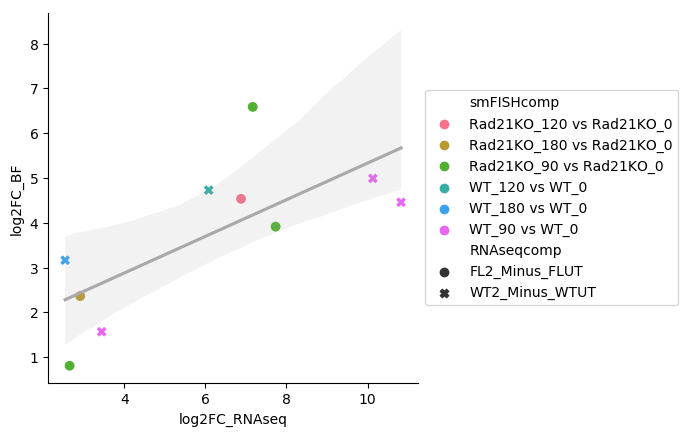

RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x1 and `#JL`$y1
t = 2.933, df = 8, p-value = 0.01891
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1649698 0.9285943
sample estimates:
     cor 
0.719828 



In [5]:
function dysplay_correlation(tb, x, y; style = "RNAseqcomp", hue = "smFISHcomp")
    bool1 = .! isnan.(tb[!,x]); bool2 = .! isnan.(tb[!,y])
    nonantb = tb[bool1.*bool2, :]
    sort!(nonantb, "smFISHcomp")
    x1 = [ii for ii in nonantb[!,x]]
    y1 = [ii for ii in nonantb[!,y]]
    
    pdt = Pandas.DataFrame(nonantb)

    
    py"""
    import seaborn as sns
    sns.scatterplot(data = $pdt, x= $x, y = $y, hue = $hue, style = $style, palette = "husl", s = 50, linewidth = 0, 
    #hue_order = ["WT_60 vs WT_0","WT_90 vs WT_0","WT_120 vs WT_0","WT_135 vs WT_0","WT_180 vs WT_0"]
    )
    
    sns.regplot(data = $pdt, x= $x, y = $y, scatter = 0, color = "darkgray")

    """
    pretty_axes2()
    legend_out_of_plot()
    squareplot()
    R"cor.test($x1,$y1)"
    
end



dysplay_correlation(tb_sum, "log2FC_RNAseq", "log2FC_BF", style = "RNAseqcomp",)



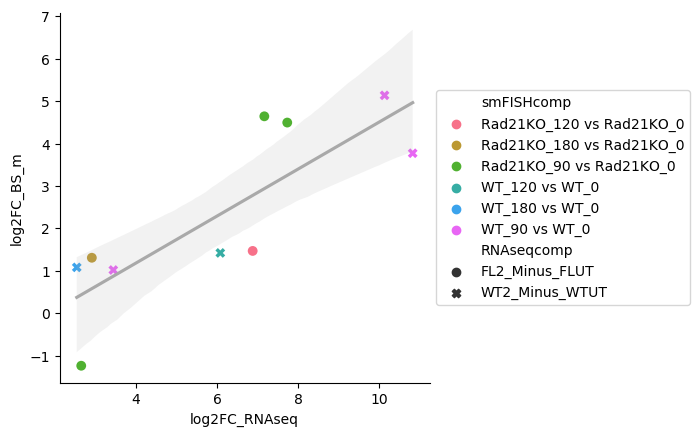

RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x1 and `#JL`$y1
t = 4.0665, df = 8, p-value = 0.003601
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3960207 0.9562815
sample estimates:
      cor 
0.8209478 



In [6]:
dysplay_correlation(tb_sum, "log2FC_RNAseq", "log2FC_BS_m", style = "RNAseqcomp",)

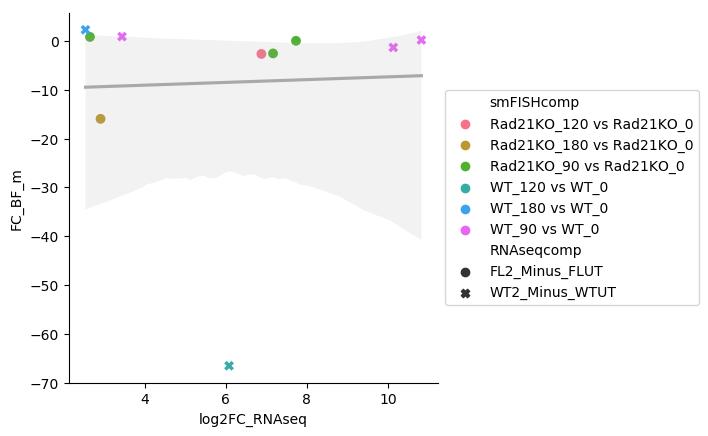

RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x1 and `#JL`$y1
t = 0.11746, df = 8, p-value = 0.9094
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6039107  0.6540325
sample estimates:
       cor 
0.04149272 



In [7]:
dysplay_correlation(tb_sum, "log2FC_RNAseq", "FC_BF_m", style = "RNAseqcomp",)


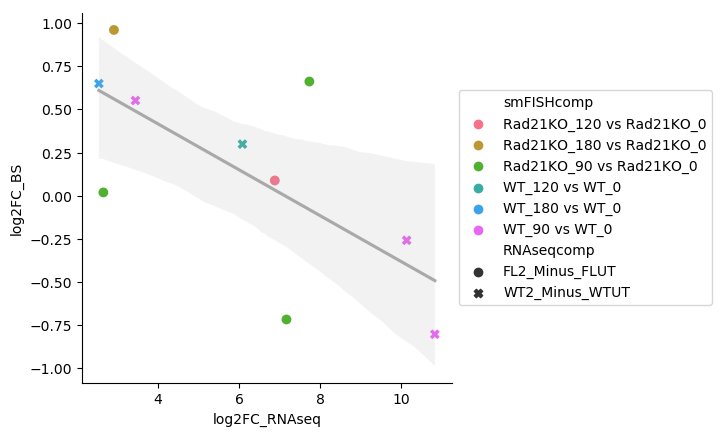

RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x1 and `#JL`$y1
t = -2.6557, df = 8, p-value = 0.029
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.91833933 -0.09642728
sample estimates:
       cor 
-0.6844957 



In [8]:
dysplay_correlation(tb_sum, "log2FC_RNAseq", "log2FC_BS", style = "RNAseqcomp",)